In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torchinfo import summary
import torch.nn.functional as F

import io
import os
import re
import tiktoken

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Version ou on change juste le sigmoid pour limiter les messages détectés en SPAM

Chargement des données

In [2]:
df = pd.read_csv('data/spam_v2.csv')
df.head()

,texte,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni... nan nan nan,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


Tokenisation avec o200k_base tokenizer utilisé dans GPT-4.

In [3]:
# On encode le texte avec le tokenizer sur une base de 100k tokens
tokenizer = tiktoken.get_encoding("o200k_base") 

# Fonction d'encodage des textes
def encode_texts(texts):
    return [tokenizer.encode(text) for text in texts]

df['token'] = encode_texts(df['texte'])

# Visualisation des 10 premiers tokens du premier message
df['token'].head(5)

0    [11976, 4609, 14026, 705, 2438, 11, 21528, 485...
1    [14999, 34160, 1008, 643, 16502, 286, 366, 337...
2    [11480, 7251, 306, 220, 17, 261, 84096, 423, 1...
3    [52, 23961, 2891, 813, 6047, 5683, 1008, 601, ...
4    [147299, 357, 4128, 2411, 501, 8805, 316, 765,...
Name: token, dtype: object

In [5]:
df['len']=df['token'].apply(len)

In [9]:
def pad_sequences(sequences, max_length=35):
    return [seq[:max_length] + [0] * (max_length - len(seq)) for seq in sequences]

df['token_pad'] = pad_sequences(df['token'])
df['len_pad']=df['token_pad'].apply(len)

On créé le dataset pytorch

In [10]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

class SmsDataset(Dataset):
    def __init__(self, df):
        self.texts = torch.tensor(df['token_pad'].tolist(), dtype=torch.long)
        self.labels = torch.tensor(df['target'].values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Création du Dataset
train_dataset = SmsDataset(train_df)
val_dataset = SmsDataset(val_df)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [11]:
text, label = next(iter(train_loader))
print(text)

tensor([[  3335,    501,   5424,  ...,      0,      0,      0],
        [ 44349,   6933,    889,  ...,      0,      0,      0],
        [ 15390,   2966,    220,  ...,      0,      0,      0],
        ...,
        [    40,   4271,  14705,  ...,      0,      0,      0],
        [    59, 111642,   2699,  ...,   8519,    415,   2912],
        [ 49322, 147355,   7068,  ...,   1507,     78,   1661]])


In [12]:
vocab_size = tokenizer.n_vocab
print(f'Le tokenizer o200k_base contient {vocab_size} tokens')

Le tokenizer o200k_base contient 200019 tokens


In [13]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_class)

    def forward(self, text):
        embedded = self.embedding(text)
        pooled = self.pooling(embedded.permute(0, 2, 1)).squeeze(2)
        return self.fc(pooled)

model = TextClassifier(vocab_size=vocab_size,
                      embed_dim=32,
                      num_class=1)

print(model)

TextClassifier(
  (embedding): Embedding(200019, 32, padding_idx=0)
  (pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [14]:
summary(model, input_data=text)

Layer (type:depth-idx)                   Output Shape              Param #
TextClassifier                           [32, 1]                   --
├─Embedding: 1-1                         [32, 35, 32]              6,400,608
├─AdaptiveAvgPool1d: 1-2                 [32, 32, 1]               --
├─Linear: 1-3                            [32, 1]                   33
Total params: 6,400,641
Trainable params: 6,400,641
Non-trainable params: 0
Total mult-adds (M): 204.82
Input size (MB): 0.01
Forward/backward pass size (MB): 0.29
Params size (MB): 25.60
Estimated Total Size (MB): 25.90

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, val_loader, criterion, optimizer, epochs=50):

    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):  
        model.train()  
        total_loss, correct = 0, 0  

        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()  
            outputs = model(inputs).squeeze(-1)  
            loss = criterion(outputs, labels.float())  
            loss.backward()  
            optimizer.step()  
            total_loss += loss.item()  
            correct += ((torch.sigmoid(outputs) > 0.7).long() == labels.long()).sum().item()  

        # Compute average loss and accuracy for training
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)

        # Validation phase (without gradient computation)
        model.eval()  
        val_loss, val_correct = 0, 0
        with torch.no_grad():  
            for inputs, labels in val_loader:
                outputs = model(inputs).squeeze(-1)  
                loss = criterion(outputs, labels.float())  
                val_loss += loss.item()  
                val_correct += ((torch.sigmoid(outputs) > 0.7).long() == labels.long()).sum().item()  

        # Compute average loss and accuracy for validation
        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)

        # Store metrics in history dictionary
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)

        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history 

history = train(model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=50)

Epoch [1/50], Loss: 0.6190, Acc: 0.8661, Val Loss: 0.5204, Val Acc: 0.8655
Epoch [2/50], Loss: 0.4298, Acc: 0.8663, Val Loss: 0.3489, Val Acc: 0.8682
Epoch [3/50], Loss: 0.2838, Acc: 0.8770, Val Loss: 0.2403, Val Acc: 0.8933
Epoch [4/50], Loss: 0.1928, Acc: 0.9118, Val Loss: 0.1767, Val Acc: 0.9247
Epoch [5/50], Loss: 0.1384, Acc: 0.9423, Val Loss: 0.1393, Val Acc: 0.9426
Epoch [6/50], Loss: 0.1052, Acc: 0.9585, Val Loss: 0.1169, Val Acc: 0.9534
Epoch [7/50], Loss: 0.0840, Acc: 0.9672, Val Loss: 0.1023, Val Acc: 0.9587
Epoch [8/50], Loss: 0.0694, Acc: 0.9729, Val Loss: 0.0927, Val Acc: 0.9623
Epoch [9/50], Loss: 0.0589, Acc: 0.9751, Val Loss: 0.0859, Val Acc: 0.9650
Epoch [10/50], Loss: 0.0513, Acc: 0.9776, Val Loss: 0.0809, Val Acc: 0.9659
Epoch [11/50], Loss: 0.0447, Acc: 0.9798, Val Loss: 0.0768, Val Acc: 0.9686
Epoch [12/50], Loss: 0.0388, Acc: 0.9832, Val Loss: 0.0737, Val Acc: 0.9722
Epoch [13/50], Loss: 0.0344, Acc: 0.9854, Val Loss: 0.0713, Val Acc: 0.9731
Epoch [14/50], Loss: 

📊 Rapport de classification :
              precision    recall  f1-score   support

         Ham      0.983     0.997     0.990       965
        Spam      0.978     0.887     0.930       150

    accuracy                          0.982      1115
   macro avg      0.980     0.942     0.960      1115
weighted avg      0.982     0.982     0.982      1115



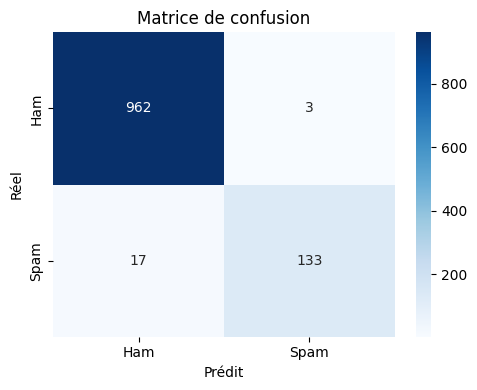

In [22]:
model = model.to(device)
model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(inputs.device, labels.device)
        # print(next(model.parameters()).device)
        
        logits = model(inputs).squeeze()
        probs = torch.sigmoid(logits)              # Probabilités (entre 0 et 1)
        preds = (probs > 0.7).int()                # Seuil à 0.5

        # Rapatrier sur CPU pour scikit-learn
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

print("📊 Rapport de classification :")
print(classification_report(y_true, y_pred, target_names=['Ham', 'Spam'], digits=3))

# --- Matrice de confusion ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.tight_layout()
plt.show()


En regardant la matrice de confusion, il n'est pas intéressant de modifier le seuil sigmoid à 0.7. Cela permet juste de réduire d'un les faux spams pour perdre également 3 détections correctes.